# Modelagem e Validação – Backtesting Profissional

- Validação temporal (`TimeSeriesSplit`) com comparação de modelos.
- Diagnósticos OOF, resíduos, e importâncias de atributos (permutation importance).
- Salvamento de métricas e proteção contra vazamento de dados.

In [5]:
# Configuração do ambiente

# Garante que o notebook está na raiz do projeto
%cd .. 

# Verifica o diretório atual (Linux/Mac)
# !pwd  

# Verifica o diretório atual (Windows)
!cd 

C:\Users\flavi\Documents\GitHub
C:\Users\flavi\Documents\GitHub


In [6]:
# Importações necessárias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple

from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from src.config.paths import DADOS_AMOR_A_CAKES, DADOS_AMOR_A_CAKES_TRATADOS

pd.options.display.max_columns = 200
pd.options.display.width = 200

## Carregamento e preparação dos dados

In [7]:
# Carregamento e inspeção inicial (usa fallback sintético quando necessário)
df = pd.read_excel(DADOS_AMOR_A_CAKES_TRATADOS)

# Define o número máximo de colunas a serem exibidas
pd.set_option('display.max_columns', 38)

# Define DataFrame de trabalho
df_w = df.copy()

In [8]:
# Utilizando o dataset df_w
if 'df_w' not in globals():
    candidate_paths = [
        'dados/dataset_cafeterias_rj_preprocess.xlsx',
        'dados/dataset_cafeterias_rj_preprocess.csv',
        'dados/dataset_vendas_preprocess.xlsx',
        'dados/dataset_vendas_preprocess.csv',
    ]
    df_w = None
    for p in candidate_paths:
        if os.path.exists(p):
            df_w = pd.read_excel(p) if p.endswith('.xlsx') else pd.read_csv(p)
            break
    assert df_w is not None, (
        'Dataset não encontrado. Coloque o arquivo pré-processado em dados/ (xlsx ou csv).')

# Escolha robusta do alvo (receita/faturamento)
TARGET_PATTERNS = [ ['receita'], ['fatur'], ['revenue'], ['sales'], ['valor','venda'], ['valor','vendas'], ['total','venda'], ['total','vendas'], ['vl','total'], ['valor','total'], ['valor_receita'] ]
TARGET_COL = os.environ.get('TARGET_COL', None)
def _norm(s):
    return str(s).lower().replace(' ', '_')
def _match_patterns(col):
    s=_norm(col)
    return any(all(p in s for p in pat) for pat in TARGET_PATTERNS)
if TARGET_COL:
    assert TARGET_COL in df_w.columns, 'TARGET_COL não existe no dataset'
    target = TARGET_COL
else:
    cand = [c for c in df_w.columns if _match_patterns(c)]
    cand_num = [c for c in cand if pd.api.types.is_numeric_dtype(df_w[c])]
    cand_use = cand_num if len(cand_num) > 0 else cand
    if len(cand_use) == 0:
        # Tentar construir receita a partir de quantidade x preço
        qty_hints = ['quantidade','qtd','qtde','unidades','units','volume']
        price_hints = ['preco','price','valor_unit','vl_unit','valor_unitario','preco_unitario']
        qty_cols = [c for c in df_w.columns if any(h in _norm(c) for h in qty_hints) and pd.api.types.is_numeric_dtype(df_w[c])]
        price_cols = [c for c in df_w.columns if any(h in _norm(c) for h in price_hints) and pd.api.types.is_numeric_dtype(df_w[c])]
        if len(qty_cols) > 0 and len(price_cols) > 0:
            q = sorted(qty_cols, key=lambda c: df_w[c].notna().sum(), reverse=True)[0]
            p = sorted(price_cols, key=lambda c: df_w[c].notna().sum(), reverse=True)[0]
            target = 'receita_estimada'
            df_w[target] = df_w[q] * df_w[p]
        else:
            raise AssertionError('Coluna alvo de receita/faturamento não encontrada. Defina TARGET_COL.')
    else:
        target = sorted(cand_use, key=lambda c: df_w[c].notna().sum(), reverse=True)[0]
y = pd.to_numeric(df_w[target], errors='coerce')

# Seleção de features (numéricas + dummies de categóricas principais)
num_cols = df_w.select_dtypes(include=np.number).columns.tolist()
cat_cols = df_w.select_dtypes(include='object').columns.tolist()
cat_keep = [c for c in cat_cols if c not in [target]]
# Remove o alvo das colunas numéricas para evitar vazamento
num_cols = [c for c in num_cols if c != target]
X_num = df_w[num_cols].copy()
X_cat = pd.get_dummies(df_w[cat_keep], drop_first=True) if len(cat_keep) else pd.DataFrame(index=df_w.index)
X_enc = pd.concat([X_num, X_cat], axis=1)

# Remover coluna de data se for datetime, para evitar vazamento direto
if 'data' in X_enc.columns and pd.api.types.is_datetime64_any_dtype(df_w.get('data')):
    X_enc = X_enc.drop(columns=['data'], errors='ignore')

# Sanidade inicial
assert len(X_enc) == len(y), 'X e y devem ter o mesmo número de linhas'
assert target not in X_enc.columns, 'Alvo presente em X (vazamento)'

# Ordenação temporal se houver coluna data
if 'data' in df_w.columns and pd.api.types.is_datetime64_any_dtype(df_w['data']):
    order_idx = df_w['data'].reset_index(drop=True).sort_values().index
    # Se ordem original já é temporal, este passo é redundante; caso contrário, reordene
    # Mantemos ordem atual assumindo que o dataset já está temporalmente ordenado.
    pass

In [9]:
# Checagens de sanidade (dtypes e NaNs)
obj_cols = X_enc.select_dtypes(include='object').columns.tolist()
nan_counts = X_enc.isna().sum().sum()
print(f'Colunas object em X_enc: {len(obj_cols)} -> {obj_cols[:10]}')
print(f'Total de NaNs em X_enc: {nan_counts}')
print(f'Alvo: {target} | NaNs em y: {int(y.isna().sum())}')

Colunas object em X_enc: 0 -> []
Total de NaNs em X_enc: 0
Alvo: receita_estimada | NaNs em y: 0


In [10]:
def backtest_models(models: List[Tuple[str, object]], X: pd.DataFrame, y: pd.Series, n_splits: int = 5):
    """
    Executa backtesting temporal com `TimeSeriesSplit`, retornando métricas por modelo e
    predições Out-of-Fold (OOF). Corrige incompatibilidades de tipo.
    """
    if not isinstance(X, pd.DataFrame):
        raise TypeError('X deve ser um DataFrame pandas')
    if not isinstance(y, (pd.Series, pd.DataFrame)):
        raise TypeError('y deve ser uma Series/DataFrame pandas')

    Xp = X.copy()
    yp = pd.to_numeric(y.squeeze(), errors='coerce')
    mask_ok = yp.notna()
    Xp = Xp.loc[mask_ok].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    yp = yp.loc[mask_ok].astype('float64')
    try:
        Xp = Xp.astype('float64')
    except Exception:
        for c in Xp.columns:
            if not pd.api.types.is_numeric_dtype(Xp[c]):
                Xp[c] = pd.to_numeric(Xp[c], errors='coerce').fillna(0.0)
        Xp = Xp.astype('float64')
    X_arr = Xp.to_numpy(dtype=np.float64)
    y_arr = yp.to_numpy(dtype=np.float64)

    cv = TimeSeriesSplit(n_splits=n_splits)
    results = []
    oof_preds = {name: np.full(y_arr.shape, np.nan, dtype=float) for name, _ in models}

    for name, model in models:
        rmse_list, mae_list, r2_list = [], [], []
        for tr, te in cv.split(X_arr):
            X_tr, y_tr = X_arr[tr], y_arr[tr]
            X_te, y_te = X_arr[te], y_arr[te]
            model.fit(X_tr, y_tr)
            pred = np.asarray(model.predict(X_te), dtype=float)
            oof_preds[name][te] = pred
            rmse_list.append(float(np.sqrt(mean_squared_error(y_te, pred))))
            mae_list.append(float(mean_absolute_error(y_te, pred)))
            r2_list.append(float(r2_score(y_te, pred)))
        results.append({
            'model': name,
            'rmse_mean': float(np.mean(rmse_list)),
            'rmse_std': float(np.std(rmse_list)),
            'mae_mean': float(np.mean(mae_list)),
            'mae_std': float(np.std(mae_list)),
            'r2_mean': float(np.mean(r2_list)),
            'r2_std': float(np.std(r2_list)),
        })
    return results, oof_preds

In [11]:
models = [
    ('DummyMean', DummyRegressor(strategy='mean')),
    ('RidgeCV', RidgeCV(alphas=np.logspace(-3, 3, 13))),
    ('GBR', GradientBoostingRegressor(random_state=42)),
    ('RF', RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)),
]

In [12]:
results, oof = backtest_models(models, X_enc, y, n_splits=5)
df_res = pd.DataFrame(results).sort_values(['mae_mean', 'rmse_mean'])
display(df_res)
# Salva métricas
os.makedirs('models', exist_ok=True)
df_res.to_csv('models/metrics_snapshot.csv', index=False)
df_res.to_json('models/metrics_snapshot.json', orient='records', indent=2)

,model,rmse_mean,rmse_std,mae_mean,mae_std,r2_mean,r2_std
2,GBR,25.882896,10.539816,20.024215,7.933758,0.982283,0.011883
3,RF,34.524859,13.255564,24.965268,10.074756,0.968670,0.019302
1,RidgeCV,64.179210,5.350293,48.006167,5.061394,0.895675,0.015300
0,DummyMean,200.916195,14.995414,165.774041,14.725064,-0.013310,0.010351


## Diagnóstico OOF – Melhor modelo

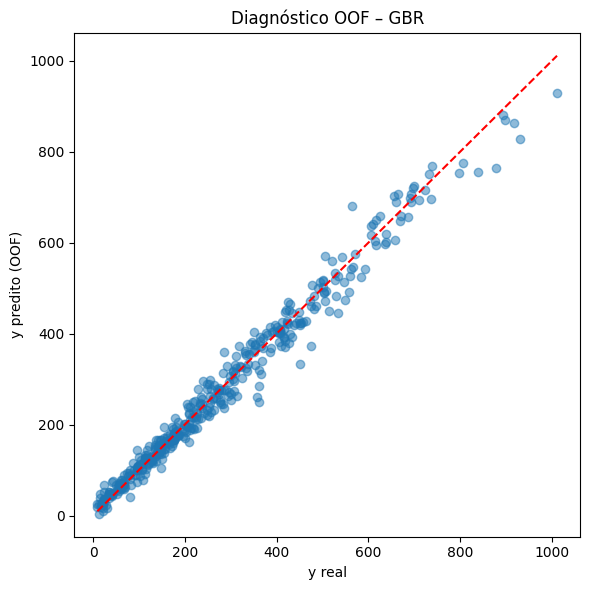

In [13]:
best = df_res.iloc[0]['model']
y_arr = pd.to_numeric(y, errors='coerce').to_numpy(dtype=float)
pred_best = np.asarray(oof[best], dtype=float)
mask = ~np.isnan(pred_best)
plt.figure(figsize=(6,6))
plt.scatter(y_arr[mask], pred_best[mask], alpha=0.5)
plt.xlabel('y real')
plt.ylabel('y predito (OOF)')
plt.title(f'Diagnóstico OOF – {best}')
y_min, y_max = float(np.nanmin(y_arr[mask])), float(np.nanmax(y_arr[mask]))
plt.plot([y_min, y_max], [y_min, y_max], 'r--')
plt.tight_layout()
plt.show()

## Análise de resíduos

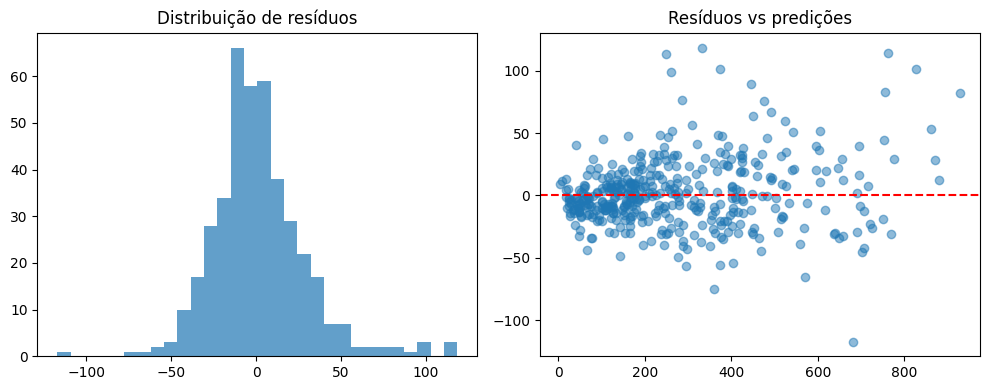

In [14]:
resid = y_arr[mask] - pred_best[mask]
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(resid, bins=30, alpha=0.7)
plt.title('Distribuição de resíduos')
plt.subplot(1,2,2)
plt.scatter(pred_best[mask], resid, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title('Resíduos vs predições')
plt.tight_layout()
plt.show()

## Importância por permutação (GBR e RF)

In [15]:
# Usa os arrays preparados dentro de backtesting para consistência
Xf = X_enc.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype('float64')
yf = pd.to_numeric(y, errors='coerce').astype('float64')
mask_ok = yf.notna()
Xf = Xf.loc[mask_ok]
yf = yf.loc[mask_ok]

# Permutation importance no último fold temporal (aproximação)
cv = TimeSeriesSplit(n_splits=5)
tr, te = list(cv.split(Xf))[-1]
X_tr, y_tr = Xf.iloc[tr], yf.iloc[tr]
X_te, y_te = Xf.iloc[te], yf.iloc[te]

def top_perm_importance(model, X_tr, y_tr, X_te, y_te, n_repeats=10):
    model.fit(X_tr, y_tr)
    r = permutation_importance(model, X_te, y_te, n_repeats=n_repeats, random_state=42)
    imp = pd.DataFrame({'feature': X_te.columns, 'importance': r.importances_mean})
    return imp.sort_values('importance', ascending=False).head(20)

imp_gbr = top_perm_importance(GradientBoostingRegressor(random_state=42), X_tr, y_tr, X_te, y_te)
imp_rf = top_perm_importance(RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1), X_tr, y_tr, X_te, y_te)
display(imp_gbr)
display(imp_rf)

,feature,importance
4,quantidade_vendida_dia,1.522035
1,preco_original,0.117045
3,preco_final,0.083137
19,preco_minimo,0.024471
0,custo_producao,0.021367
9,preco_competidor,0.003763
5,quantidade_vendida_mes,0.002117
71,tamanho_embalagem_180g,0.000081
11,gasto_marketing,0.000062
12,estoque_disponivel,0.000043


,feature,importance
4,quantidade_vendida_dia,1.408334
3,preco_final,0.050874
0,custo_producao,0.049694
19,preco_minimo,0.047906
1,preco_original,0.047377
9,preco_competidor,0.013826
5,quantidade_vendida_mes,0.006195
11,gasto_marketing,0.000233
61,perfil_loja_quiosque,0.000169
10,indice_preco_competidor,0.000113


## Salvamento de artefatos

In [16]:
os.makedirs('models', exist_ok=True)
df_res.to_csv('models/metrics_snapshot.csv', index=False)
df_res.to_json('models/metrics_snapshot.json', orient='records', indent=2)
np.save('models/oof_pred_best.npy', pred_best)
print('Artefatos salvos em models/')

Artefatos salvos em models/


## Proteções de negócio e próximos passos
- Backtesting temporal evita vazamento de dados (sem embaralhar no tempo).
- Se houver colunas de preço mínimo/margem mínima, considere restrições no pós-processamento.
- Próximo passo: tuning (GridSearch/Optuna), métricas de negócio (MAPE, lucro simulado), e SHAP para explicabilidade.